<a href="https://colab.research.google.com/github/ChrisKantor/Deep-Learning/blob/main/Homework%203/Deep_Learning_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Deep Learning Assignment Notes:
#Need to submit 3 things, training code, the trained model, and then a bunch of results.
#need to try all of the things listed in q2
#lots of tial and eror with the hyperparameter tuning

#data set is about baby vitals for detecting baby pain
#3 classes: no pain, mild pain, lots of pain
#col 1 is heart rate
#col 2 is respiratory rate
#col 3 is oxygen saturation
#Can merge all the csv files into 1 large one
#randomize and then split into training/validation data

#need to clean the data, invalid data could be in any column

#need 5 HIDDEN layers, so 7 total with the input and output layers
#We can choose any number of neurons per layer

#70% accuracy is a good minimum

#Submit the best model only, but save figures for the other models with hyperparameter tuning
#the model is not enough, need to submit a script which loads the model and then runs the test dataset on it
#the testing script can be on a seperate cell in the notebook

#figures are for validation loss
#don't need to combine hyperparameters, just do them without each other, should be 12 figures total for part 2
#1 figure for part 1 (the best model)

# **Loading Dataset**

In [129]:
#import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import os
from matplotlib import pyplot as plt

## Mount Google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/HW3/Homework 3 Data/'

mainFile = "baby_data.csv"

Mounted at /content/drive


In [33]:
#create a new csv file that will hold all of our valid data
with open("/content/drive/MyDrive/Colab Notebooks/Deep Learning/HW3/" + mainFile, 'w') as csvfile:
  csvwriter = csv.writer(csvfile)

  # writing the column names
  csvwriter.writerow(['Heart Rate', 'Respiratory Rate', 'O2 Level', 'Label'])

  #use the os library to iterate through all files in the current path
  for (root,dirs,files) in os.walk(data_dir, topdown=True):
    #open each CSV file, we don't want to open any other type of file
    for f in files:
      if f.endswith(".csv"):
        #in each file, go through each row and check if it is valid
        with open(os.path.join(root, f), mode ='r') as csvFile:
          csvData = csv.reader(csvFile)

          #one way to tell if the data is invalid is if the label is NOT [0, 1, 2]. This means there was something wrong with one of the sensors at the time of capture
          #another way is to check if the heart rate, respiratory rate, or o2 level is too low or too high
          #for heart Rate, we want a range of 44 - 200
          #for Respiratory Rate, we want a range of 18 - 90
          #for o2 level, we want a rate of 80 - 100
          for row in csvData:
            try:
              if row[4] in "012" and (int(row[1]) >= 44 and int(row[1]) <= 200) and (int(row[2]) >= 18 and int(row[2]) <= 90) and (int(row[3]) >= 80 and int(row[3]) <= 100):   #data is valid, so add it to the main csv

                #row[0] just stores the row # in the csv file, so it is not needed in the training dataset
                csvwriter.writerow([row[1], row[2], row[3], row[4]])

            #Catches errors that occur when an element cannot be parsed into an integer. In this case the row is invalid so we can skip it
            except ValueError:
              continue

print("Done writing to main csv file: ", mainFile)

Done writing to main csv file:  baby_data.csv


In [130]:
#Now we have a csv file that has ALL of the valid data which we will use in training our model
#The next step is to split the data into a training and validation set, using a 90/10 split
dataframe = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Deep Learning/HW3/" + mainFile, sep=',')
print(dataframe.shape)
print(dataframe.head())


#split the data into a training and validation set using a 90/10 split, and randomize beforehand
trainData, valData = np.split(dataframe.sample(frac=1), [int(0.9*len(dataframe))])

#save the labels to a seperate dataframe and remove them from the data dataframe
trainLabel = trainData.pop('Label')
valLabel = valData.pop('Label')

(14423, 4)
   Heart Rate  Respiratory Rate  O2 Level  Label
0         172                46        98      2
1         172                46        98      2
2         173                46        98      2
3         175                48        98      2
4         172                49        98      2


In [131]:
#Hyperparameter Tuning
batchSize = 32
learningRate = 0.0001
numEpochs = 50
normalize = False
optType = 'Adam'
momentum = 0.9
initType = 'Default'
regularize = False         #using L2 regularization in tensorflow
regularizeLamda = 0.0001



#Choosing optimizer
if optType == 'Adam':
  opt = tf.keras.optimizers.Adam(learning_rate = learningRate)

elif optType == 'SGD':
  opt = tf.keras.optimizers.SGD(learning_rate = learningRate, momentum = momentum)


#using a random weight initializer
if initType == 'Random':
  initializer = tf.keras.initializers.RandomUniform(minval=0.0, maxval=1.0, seed = 8312001)

#use the default initizalizer, the Xavier/Golrot initializer
else:
  initializer = tf.keras.initializers.GlorotUniform(seed = 8312001)


#Normalizing data
#normFactors stores the column maximums so we can normalize our validation and test data with the same factors we found in our training data
normFactors = {}

if normalize:
  for col in trainData.columns:
    normFactors[col] = trainData[col].abs().max()
    trainData[col] = trainData[col]  / normFactors[col]
    valData[col] = valData[col]  / normFactors[col]

print(normFactors)

{}


# Model Creation and Training

In [132]:
#Create the model
if regularize:
  model = tf.keras.models.Sequential([
    tf.keras.layers.Input(3, kernel_initializer=initializer),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(regularizeLamda), kernel_initializer=initializer),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(regularizeLamda), kernel_initializer=initializer),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(regularizeLamda), kernel_initializer=initializer),
    tf.keras.layers.Dense(3, kernel_initializer=initializer)
  ])

else:
  model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(3, kernel_initializer=initializer),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer=initializer),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer),
    tf.keras.layers.Dense(3, kernel_initializer=initializer)
  ])


#creating the loss function we will use
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt,
              loss=loss_fn,
              metrics=['accuracy'])


#or optionally load a model from a file
# model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Deep Learning/HW3/bestModel.keras")

In [133]:
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/HW3/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


#Running the model
print("Running Model\n")
history = model.fit(trainData, trainLabel, epochs=numEpochs, batch_size=batchSize, validation_data=(valData, valLabel), callbacks=[model_checkpoint_callback])


#load the best model using the callback
model.load_weights(checkpoint_filepath)

print("\n\nEvaluating Best Model\n")
#evaluation the model on the validation data
model.evaluate(valData, valLabel, verbose=2)

Running Model

Epoch 1/50
406/406 [==============================] - 2s 3ms/step - loss: 1.5947 - accuracy: 0.5172 - val_loss: 0.8521 - val_accuracy: 0.6681
Epoch 2/50
406/406 [==============================] - 1s 2ms/step - loss: 1.0047 - accuracy: 0.5680 - val_loss: 0.7632 - val_accuracy: 0.6861
Epoch 3/50
406/406 [==============================] - 1s 2ms/step - loss: 0.8669 - accuracy: 0.6055 - val_loss: 0.7379 - val_accuracy: 0.6895
Epoch 4/50
406/406 [==============================] - 1s 2ms/step - loss: 0.8165 - accuracy: 0.6303 - val_loss: 0.7299 - val_accuracy: 0.6847
Epoch 5/50
406/406 [==============================] - 1s 2ms/step - loss: 0.7851 - accuracy: 0.6506 - val_loss: 0.7171 - val_accuracy: 0.6875
Epoch 6/50
406/406 [==============================] - 1s 3ms/step - loss: 0.7540 - accuracy: 0.6640 - val_loss: 0.6928 - val_accuracy: 0.6979
Epoch 7/50
406/406 [==============================] - 2s 6ms/step - loss: 0.7323 - accuracy: 0.6773 - val_loss: 0.6800 - val_accuracy

[0.6233729124069214, 0.732501745223999]

In [40]:
#save the model
model.save("/content/drive/MyDrive/Colab Notebooks/Deep Learning/HW3/bestModel.keras")
print("Saved Model")

Saved Model


# Graph Results

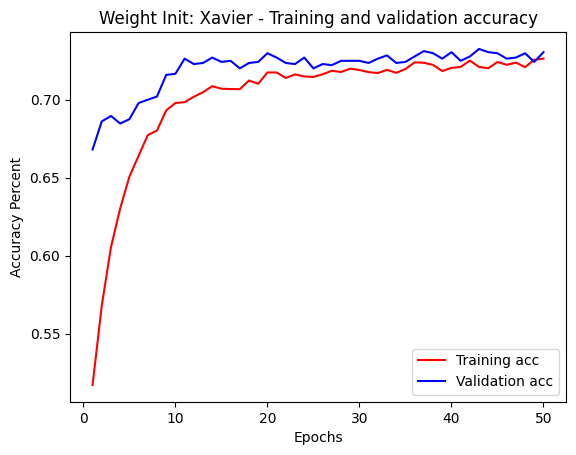

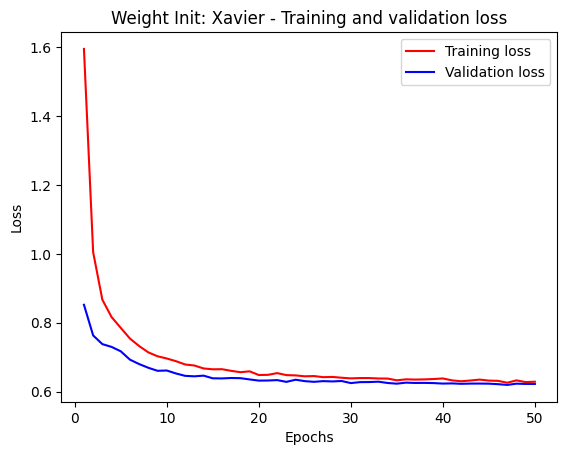

In [134]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Weight Init: Xavier - Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy Percent")
plt.legend()

#Saving the Accuracy Figure
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Deep Learning/HW3/Results/weightInit_xavier_Accuracy.png")
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Weight Init: Xavier - Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()


#Saving the Loss Figure
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Deep Learning/HW3/Results/weightInit_xavier_Loss.png")
# plt.show()

# Running Test Set for Project Grading

In [136]:
#import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import os
from matplotlib import pyplot as plt

## Mount Google drive and load test data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/HW3/'

mainFile = "test.csv"

#read test.csv, dropping the first column as it just holds the index of the rows, which we don't need
testData = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Deep Learning/HW3/" + mainFile, sep=',', usecols=[1, 2, 3, 4], names = ['Heart Rate', 'Respiratory Rate', 'O2 Level', 'Label'])
testLabel = testData.pop("Label")

#Normalize the test data using the normalization factors we found in the training data. Hard coded here
normFactors = {'Heart Rate': 199, 'Respiratory Rate': 90, 'O2 Level': 100}

for col in testData:
  testData[col] = testData[col]  / normFactors[col]

#load the model from a saved file
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Deep Learning/HW3/bestModel.keras")

#evaluation the model on the test data
loss, acc = model.evaluate(testData, testLabel, verbose=2)
print("Loss on test data: ", loss)
print("Accuracy on test data: ", acc)

Mounted at /content/drive
4/4 - 0s - loss: 0.4541 - accuracy: 0.8306 - 347ms/epoch - 87ms/step
Loss on test data:  0.4541206359863281
Accuracy on test data:  0.8306451439857483
